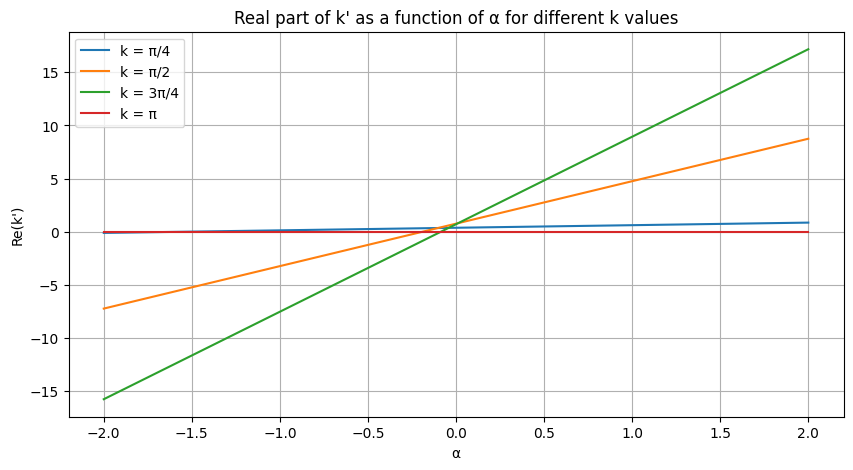

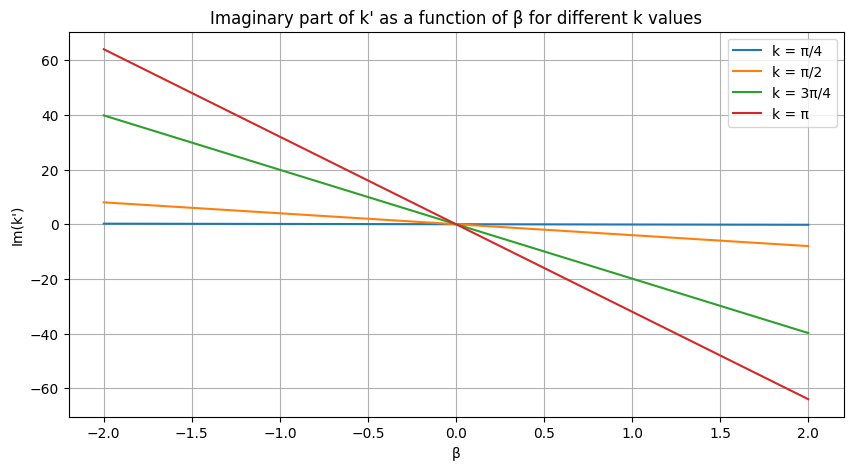

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
def Re_k_prime(alpha, k):
    return alpha * np.sin(3*k) + (-4*alpha - 1/6) * np.sin(2*k) + (5*alpha + 4/3) * np.sin(k)

def Im_k_prime(beta, k):
    return beta * np.cos(3*k) - 6*beta * np.cos(2*k) + 15*beta * np.cos(k) - 10*beta

# Values of k to plot
k_values = [np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
k_labels = ['π/4', 'π/2', '3π/4', 'π']

# Create a range of alpha and beta values
alpha = np.linspace(-2, 2, 100)
beta = np.linspace(-2, 2, 100)

# Plot Re(k') vs alpha
plt.figure(figsize=(10, 5))
for k, label in zip(k_values, k_labels):
    plt.plot(alpha, Re_k_prime(alpha, k), label=f'k = {label}')
plt.xlabel('α')
plt.ylabel('Re(k\')')
plt.title('Real part of k\' as a function of α for different k values')
plt.grid(True)
plt.legend()
# plt.show()
plt.savefig("real.jpg",dpi=600,bbox_inches='tight')

# Plot Im(k') vs beta
plt.figure(figsize=(10, 5))
for k, label in zip(k_values, k_labels):
    plt.plot(beta, Im_k_prime(beta, k), label=f'k = {label}')
plt.xlabel('β')
plt.ylabel('Im(k\')')
plt.title('Imaginary part of k\' as a function of β for different k values')
plt.grid(True)
plt.legend()
# plt.show()
plt.savefig("imag.jpg",dpi=600,bbox_inches='tight')

In [5]:
import numpy as np
from scipy.integrate import quad

nu = 10  # or 9, 10
def f1(k):
    return np.sin(3*k) - 4*np.sin(2*k) + 5*np.sin(k)
def f2(k):
    return -0.5*np.sin(2*k) + 0.75*np.sin(k)

numerator = quad(lambda k: np.exp(nu*(np.pi - k)) * f1(k) * (k - f2(k)), 0, np.pi)[0]
denominator = quad(lambda k: np.exp(nu*(np.pi - k)) * f1(k)**2, 0, np.pi)[0]
alpha_opt = numerator / denominator
print(f"Optimal α for ν={nu}: {alpha_opt:.6f}")

Optimal α for ν=10: 3.716124


# Problem 3

In [74]:
#DRP
def drp_derivative(u, dx, a1, a2, a3):
    
    du = (
        a1 * (np.roll(u, -1) - np.roll(u, 1)) +
        a2 * (np.roll(u, -2) - np.roll(u, 2)) +
        a3 * (np.roll(u, -3) - np.roll(u, 3))
    )
    return du / dx

In [75]:
#DRP-M
cc = np.array([
    -0.014281184692, 0.086150669577, -0.235718815308, 
    0.327698660846, -0.235718815308, 0.086150669577, 
    -0.014281184692
])

def drpm_derivative(u, dx, a1, a2, a3, epsilon=0.1):
    """Modified DRP scheme for LINEAR advection."""
    du_drp = drp_derivative(u, dx, a1, a2, a3)
    # Artificial damping term (fixed strength)
    u_rolled = np.array([np.roll(u, i) for i in [-3, -2, -1, 0, 1, 2, 3]])
    damping = -epsilon * dx * np.sum(cc[:, None] * u_rolled, axis=0)
    return du_drp + damping

In [76]:
#MDCD
def mdcd_derivative(u, dx):
    du = MDCD_flux(u,dx) - np.roll(MDCD_flux(u,dx),1)
    return du

def compute_k_ESW_MDCD(u):
    N = len(u)
    k_ESW = np.zeros(N)
    eps = 1e-40  
    
    for j in range(N):
        jm2 = (j - 2) % N
        jm1 = (j - 1) % N
        j0 = j % N
        jp1 = (j + 1) % N
        jp2 = (j + 2) % N
        jp3 = (j + 3) % N
        
        df1 = (1/96)*u[jm2] - (1/96)*u[jm1] - (49/48)*u[j0] + (49/48)*u[jp1] + \
              (1/96)*u[jp2] - (1/96)*u[jp3]
        
        df2 = (1/24)*u[jm2] + (3/8)*u[jm1] - (5/12)*u[j0] - (5/12)*u[jp1] + \
              (3/8)*u[jp2] + (1/24)*u[jp3]
        
        df3 = (1/8)*u[jm2] - (13/8)*u[jm1] + (17/4)*u[j0] - (17/4)*u[jp1] + \
              (13/8)*u[jp2] - (1/8)*u[jp3]
        
        df4 = (1/2)*u[jm2] - (3/2)*u[jm1] + u[j0] + u[jp1] - (3/2)*u[jp2] + \
              (1/2)*u[jp3]
        
        stencil = [u[jm2], u[jm1], u[j0], u[jp1], u[jp2], u[jp3]]
        f_max = np.max(stencil)
        f_min = np.min(stencil)
        eps_local = 0.005 * np.exp(-500 * max((f_max - f_min) - 0.001, 0))
        
        numerator = np.abs(df3) + np.abs(df4)
        denominator = np.abs(df1) + np.abs(df2) + eps + eps_local
        k_ESW[j] = np.sqrt(numerator / denominator)
        
    return np.clip(k_ESW, 0, np.pi)  


def gamma_diss_MDCD(k_ESW):
    k_c = 1.0      
    k_max = 2.45   
    gamma_min = 0.001  
    gamma_max = 0.012  
    
    gamma_vals = np.zeros_like(k_ESW)
    for j in range(len(k_ESW)):
        k = k_ESW[j]
        if k <= k_c:
            gamma_vals[j] = gamma_min
        else:
            g_diss = gamma_min + (gamma_max - gamma_min) * \
                     ((k - k_c) / (k_max - k_c))**0.5
            gamma_vals[j] = min(g_diss, gamma_max)
    
    return gamma_vals  

def MDCD_flux(u, dx):
    N = len(u)
    flux = np.zeros(N)
    k_ESW = compute_k_ESW_MDCD(u)
    g_disp = 0.0463783 * np.ones(N)
    g_diss = gamma_diss_MDCD(k_ESW)
    
    for j in range(N):
        jm2 = (j - 2) % N
        jm1 = (j - 1) % N
        jp1 = (j + 1) % N
        jp2 = (j + 2) % N
        jp3 = (j + 3) % N
        
        coeff = [
            (0.5*g_disp[j] + 0.5*g_diss[j]),            
            (-1.5*g_disp[j] - 2.5*g_diss[j] - 1/12),   
            (g_disp[j] + 5*g_diss[j] + 7/12),          
            (g_disp[j] - 5*g_diss[j] + 7/12),          
            (-1.5*g_disp[j] + 2.5*g_diss[j] - 1/12),  
            (0.5*g_disp[j] - 0.5*g_diss[j])            
        ]
        
        flux[j] = (coeff[0] * u[jm2] + coeff[1] * u[jm1] + 
                   coeff[2] * u[j] + coeff[3] * u[jp1] + 
                   coeff[4] * u[jp2] + coeff[5] * u[jp3]) / dx
    return flux


In [77]:
#SA-DRP
def sa_drp_derivative(u, dx):
    du = sa_drp_flux(u,dx) - np.roll(sa_drp_flux(u,dx),1)
    return du

def compute_k_ESW(u):
    eps = 1e-8
    N = len(u)
    k_ESW = np.zeros(N)
    
    for j in range(N):
        jm2 = (j - 2) % N
        jm1 = (j - 1) % N
        jp1 = (j + 1) % N
        jp2 = (j + 2) % N
        jp3 = (j + 3) % N
        
        # S1, S2 
        S1_j = u[jm1] - 2*u[j] + u[jp1]
        S2_j = (u[jm2] - 2*u[j] + u[jp2]) / 4.0
        
        # S3, S4 
        S1_jp1 = u[j] - 2*u[jp1] + u[jp2]
        S2_jp1 = (u[jm1] - 2*u[jp1] + u[jp3]) / 4.0
        
        # C1, C2 
        C1 = u[jp1] - u[j]
        C2 = (u[jp2] - u[jm1]) / 3.0
        
        numerator = (np.abs(np.abs(S1_j + S2_j) - np.abs(S1_j - S2_j)) +
                     np.abs(np.abs(S1_jp1 + S2_jp1) - np.abs(S1_jp1 - S2_jp1)) +
                     np.abs(np.abs(C1 + C2) - 0.5*np.abs(C1 - C2)) + 2*eps)
                     
        denominator = (np.abs(S1_j + S2_j) + np.abs(S1_j - S2_j) +
                       np.abs(S1_jp1 + S2_jp1) + np.abs(S1_jp1 - S2_jp1) +
                       np.abs(C1 + C2) + np.abs(C1 - C2) + eps)
        
        ratio = np.clip(numerator / denominator,0.0,1.0)
        k_ESW[j] = np.arccos(2 * min(ratio, 1.0) - 1)
        
    return k_ESW

def gamma_disp(k_ESW):
    gamma_vals = np.zeros_like(k_ESW)
    for j in range(len(k_ESW)):
        k = k_ESW[j]
        if k < 0.01:
            gamma_vals[j] = 1/30.0
        elif k < 2.5:
            numerator = k + (1/6)*np.sin(2*k) - (4/3)*np.sin(k)
            denominator = np.sin(3*k) - 4*np.sin(2*k) + 5*np.sin(k)
            if np.abs(denominator) < 1e-12:  # Handle division by zero
                gamma_vals[j] = 0.1985842
            else:
                gamma_vals[j] = numerator / denominator
        else:
            gamma_vals[j] = 0.1985842
    return gamma_vals

def gamma_diss(k_ESW):
    gamma_vals = np.zeros_like(k_ESW)
    for j in range(len(k_ESW)):
        k = k_ESW[j]
        if k <= 1.0:
            gamma_vals[j] = 0.001
        else:
            gamma_vals[j] = 0.001 + 0.011 * np.sqrt((k - 1.0)/(np.pi - 1.0))
            gamma_vals[j] = min(gamma_vals[j], 0.012)
    return gamma_vals

def sa_drp_flux(u, dx):
    N = len(u)
    flux = np.zeros(N)
    k_ESW = compute_k_ESW(u)
    g_disp = gamma_disp(k_ESW)
    g_diss = gamma_diss(k_ESW)
    
    for j in range(N):
        jm2 = (j - 2) % N
        jm1 = (j - 1) % N
        jp1 = (j + 1) % N
        jp2 = (j + 2) % N
        jp3 = (j + 3) % N
        
        coeff = [
            (0.5*g_disp[j] + 0.5*g_diss[j]),            
            (-1.5*g_disp[j] - 2.5*g_diss[j] - 1/12),   
            (g_disp[j] + 5*g_diss[j] + 7/12),          
            (g_disp[j] - 5*g_diss[j] + 7/12),          
            (-1.5*g_disp[j] + 2.5*g_diss[j] - 1/12),  
            (0.5*g_disp[j] - 0.5*g_diss[j])            
        ]
        
        flux[j] = (coeff[0] * u[jm2] + coeff[1] * u[jm1] + 
                   coeff[2] * u[j] + coeff[3] * u[jp1] + 
                   coeff[4] * u[jp2] + coeff[5] * u[jp3]) / dx
    return flux


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

c = 1.0               
CFL = 0.3             
N = 128               
x = np.linspace(0, 1, N, endpoint=False)  
dx = 1.0 / N          
dt = CFL * dx / c     
T = 10.0              
m = 5                 

u0 = np.sum([np.sin(2 * np.pi * l * x) for l in range(1, m+1)], axis=0) / m

def ana_sol(x,time):
    result = np.zeros(x.shape)
    for j in range(m):
        result += np.sin(2 * np.pi * (1+j) * (x - time))
        
    return result/m

sol = ana_sol(x, T)

a1 = 0.770882380518
a2 = -0.166705904415
a3 = 0.020843142770

def rk4_step(u, dt, dx, deriv_func, **kwargs):
    k1 = -c * deriv_func(u, dx, **kwargs)
    k2 = -c * deriv_func(u + 0.5*dt*k1, dx, **kwargs)
    k3 = -c * deriv_func(u + 0.5*dt*k2, dx, **kwargs)
    k4 = -c * deriv_func(u + dt*k3, dx, **kwargs)
    return u + dt*(k1 + 2*k2 + 2*k3 + k4)/6


schemes = {
    "DRP": {"func": drp_derivative, "args": {"a1": a1, "a2": a2, "a3": a3}},
    "DRP-M": {"func": drpm_derivative, "args": {"a1": a1, "a2": a2, "a3": a3}},
    "MDCD": {"func": mdcd_derivative, "args": {}},
    "SA-DRP": {"func": sa_drp_derivative, "args": {}},
}

results = {}
for name in schemes:
    print(f"Computing {name}...")
    u = u0.copy()
    t = 0.0
    scheme = schemes[name]
    while t < T:
        u = rk4_step(u, dt, dx, scheme["func"], **scheme["args"])
        t += dt
    results[name] = u.copy()

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(x, sol, "--", label="Analytical Solution")
for name in results:
    plt.plot(x, results[name], label=name)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.title(f"Linear Advection at t={T} (CFL={CFL}, N={N}, m={m})")
plt.grid(True)
plt.show()

# L2-error analysis
errors = {}
sol = ana_sol(x, T)
for scheme_name in results:
    u_num = results[scheme_name]
    errors[scheme_name] = np.sum((u_num - sol)**2) / N

print("\nL2 Errors:")
for scheme_name, error in errors.items():
    print(f"{scheme_name}: {error:.6e}")

Computing DRP...
Computing DRP-M...
Computing MDCD...
Computing SA-DRP...


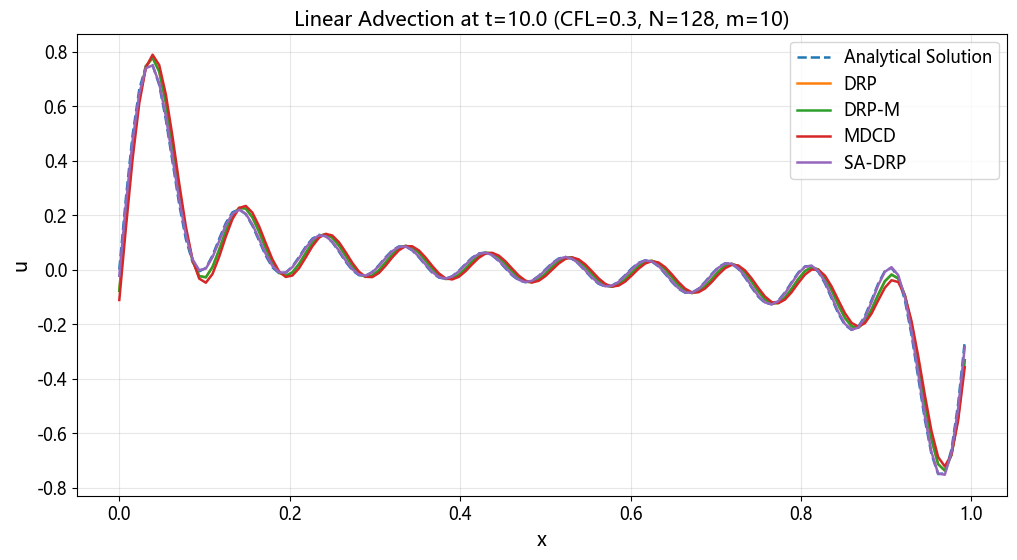

In [81]:
def ana_sol(x,time):
    result = np.zeros(x.shape)
    for j in range(m):
        result += np.sin(2 * np.pi * (1+j) * (x - time))
        
    return result/m

sol = ana_sol(x, T)

plt.figure(figsize=(12, 6))
plt.plot(x, sol, "--", label="Analytical Solution")
for name in results:
    plt.plot(x, results[name], label=name)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.title(f"Linear Advection at t={T} (CFL={CFL}, N={N}, m={m})")
plt.grid(True)
# plt.show()
plt.savefig("m10N128.jpg",dpi=600,bbox_inches='tight')

In [79]:
errors = {}
sol = ana_sol(x, T)
for scheme_name in results:
    u_num = results[scheme_name]
    errors[scheme_name] = np.sum((u_num - sol)**2) / N

print("\nL2 Errors:")
for scheme_name, error in errors.items():
    print(f"{scheme_name}: {error:.6e}")


L2 Errors:
DRP: 4.056534e+00
DRP-M: 4.056521e+00
MDCD: 4.066595e+00
SA-DRP: 4.052014e+00


# Problem 4

Computing DRP...
Computing DRP-M...
Computing MDCD...
Computing SA-DRP...


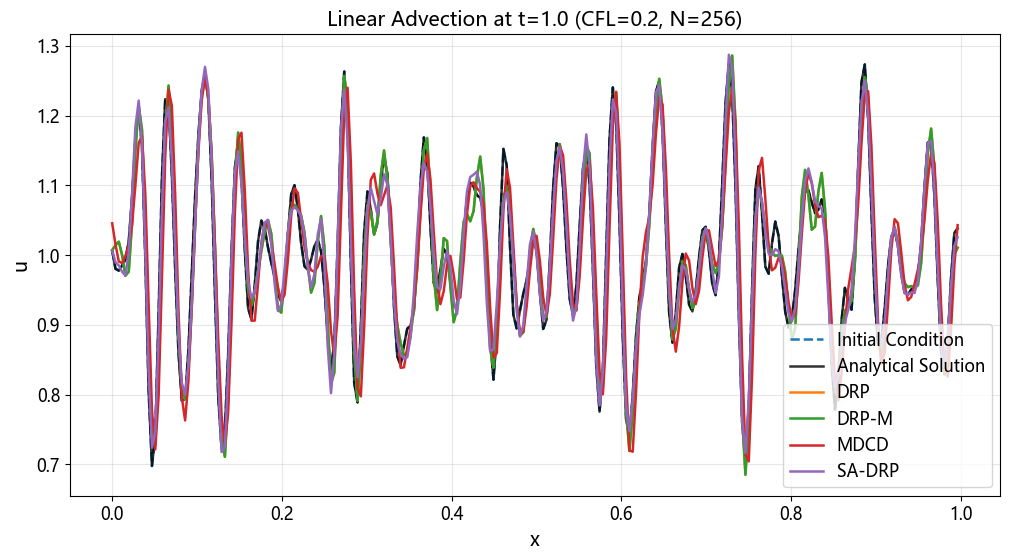


各格式的L1误差 (1-Δx范数):
DRP: 2.790714e-02
DRP-M: 2.790727e-02
MDCD: 4.529944e-02
SA-DRP: 1.985226e-02
Wall time: 7min 13s


In [70]:
%%time
import numpy as np
import matplotlib.pyplot as plt

c = 1.0               
CFL = 0.2             
N = 256               
x = np.linspace(0, 1, N, endpoint=False)  
dx = 1.0 / N          
dt = CFL * dx / c     
T = 1.0               
epsilon = 0.1         
k0 = 24               
num_k = 64            

np.random.seed(42)
psi_k = np.random.rand(num_k)  

# Initial condition: u(x,0) = 1 + ε Σ_{k=1}^64 [sqrt(E(k)) sin(2πk(x + ψ_k))]
E_k = np.array([(k/k0)**4 * np.exp(-2*(k/k0)**2) for k in range(1, num_k+1)])
sqrt_Ek = np.sqrt(E_k)

u0 = 1.0 + epsilon * np.sum([
    sqrt_Ek[k] * np.sin(2 * np.pi * (k+1) * (x + psi_k[k])) 
    for k in range(num_k)
], axis=0)

# Analytical solution (exact wave propagation)
def ana_sol(x, time):
    return 1.0 + epsilon * np.sum([
        sqrt_Ek[k] * np.sin(2 * np.pi * (k+1) * (x - time + psi_k[k])) 
        for k in range(num_k)
    ], axis=0)

sol = ana_sol(x, T)

# DRP coefficients (7-point stencil from Tam & Webb)
a1 = 0.770882380518
a2 = -0.166705904415
a3 = 0.020843142770

def rk4_step(u, dt, dx, deriv_func, **kwargs):
    k1 = -c * deriv_func(u, dx, **kwargs)
    k2 = -c * deriv_func(u + 0.5*dt*k1, dx, **kwargs)
    k3 = -c * deriv_func(u + 0.5*dt*k2, dx, **kwargs)
    k4 = -c * deriv_func(u + dt*k3, dx, **kwargs)
    return u + dt*(k1 + 2*k2 + 2*k3 + k4)/6

schemes = {
    "DRP": {"func": drp_derivative, "args": {"a1": a1, "a2": a2, "a3": a3}},
    "DRP-M": {"func": drpm_derivative, "args": {"a1": a1, "a2": a2, "a3": a3}},
    "MDCD": {"func": mdcd_derivative, "args": {}},
    "SA-DRP": {"func": sa_drp_derivative, "args": {}},
}


results = {}
for name in schemes:
    print(f"Computing {name}...")
    u = u0.copy()
    t = 0.0
    scheme = schemes[name]
    while t < T:
        u = rk4_step(u, dt, dx, scheme["func"], **scheme["args"])
        t += dt
    results[name] = u.copy()

plt.figure(figsize=(12, 6))
plt.plot(x, u0, "--", label="Initial Condition")
plt.plot(x, sol, "k-", label="Analytical Solution", alpha=0.8)
for name in results:
    plt.plot(x, results[name], label=name)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.title(f"Linear Advection at t={T} (CFL={CFL}, N={N})")
plt.grid(True)
plt.show()

errors = {}
for scheme_name in results:
    u_num = results[scheme_name]  
    u_exact = sol                 
    l1_error = np.mean(np.abs(u_num - u_exact))  
    errors[scheme_name] = l1_error

print("\n各格式的L1误差 (1-Δx范数):")
for scheme_name, err in errors.items():
    print(f"{scheme_name}: {err:.6e}")


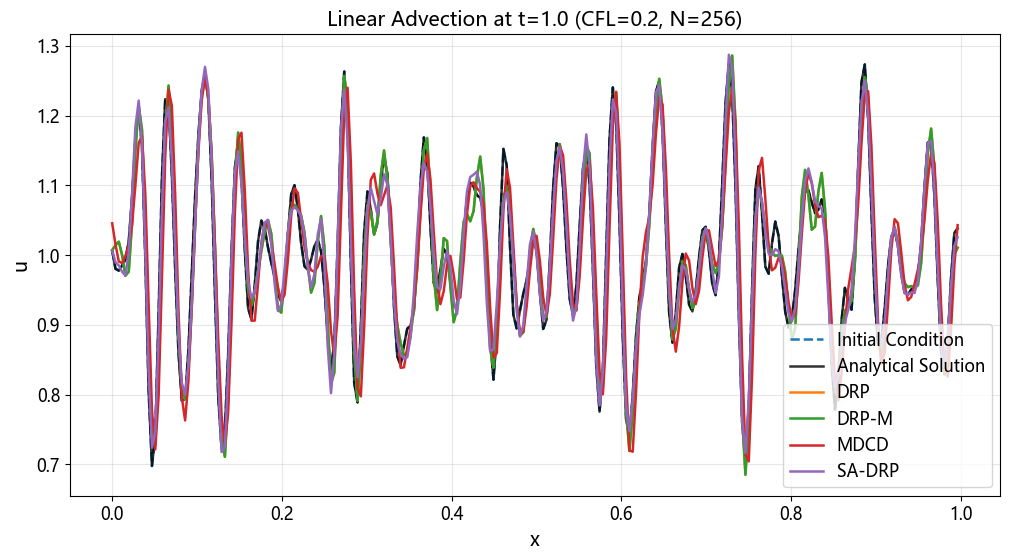

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(x, u0, "--", label="Initial Condition")
plt.plot(x, sol, "k-", label="Analytical Solution", alpha=0.8)
for name in results:
    plt.plot(x, results[name], label=name)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.title(f"Linear Advection at t={T} (CFL={CFL}, N={N})")
plt.grid(True)
# plt.show()
plt.savefig("N256m20.jpg",dpi=600,bbox_inches='tight')

In [69]:
errors = {}
for scheme_name in results:
    u_num = results[scheme_name]  
    u_exact = sol                 
    l1_error = np.mean(np.abs(u_num - u_exact))  
    errors[scheme_name] = l1_error

print("\n各格式的L1误差 (1-Δx范数):")
for scheme_name, err in errors.items():
    print(f"{scheme_name}: {err:.6e}")



各格式的L1误差 (1-Δx范数):
DRP: 1.010923e-01
DRP-M: 1.010996e-01
MDCD: 7.200437e-02
SA-DRP: 6.623119e-02


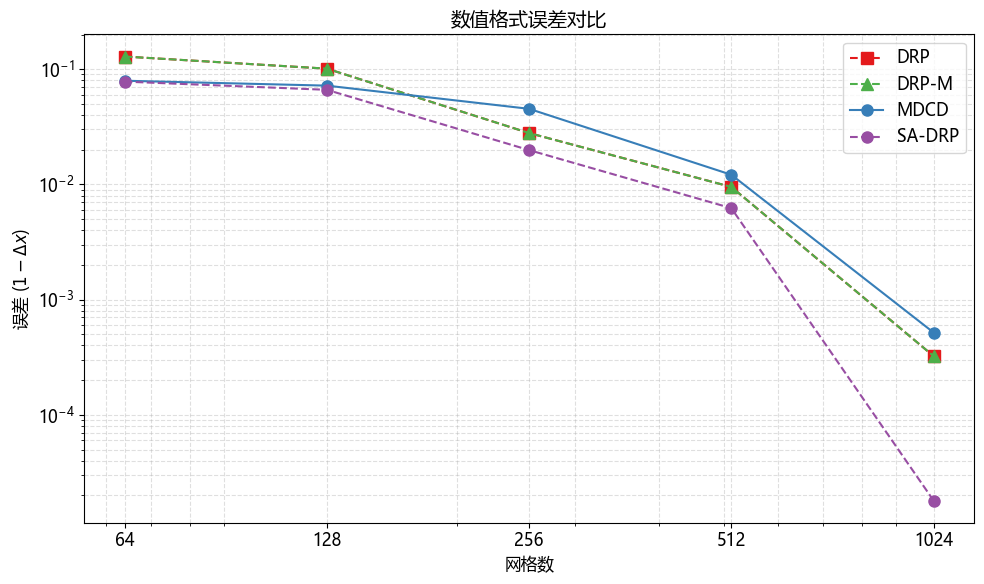

In [61]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

methods = ["DRP", "DRP-M", "MDCD", "SA-DRP"]
grids = [64, 128, 256, 512, 1024]
errors = {
    "DRP": [1.2880e-1, 1.0109e-1, 2.7907e-2, 9.5095e-3, 3.2368e-4],
    "DRP-M": [1.2882e-1, 1.0111e-1, 2.7909e-2, 9.5097e-3, 3.2370e-4],
    "MDCD": [7.9433e-2, 7.2004e-2, 4.5299e-2, 1.2130e-2, 5.1842e-4],
    "SA-DRP": [7.8048e-2, 6.6231e-2, 1.9852e-2, 6.2212e-3, 1.8051e-5]
}

style_config = {
    "DRP":    {"color": "#E41A1C", "marker": "s", "linestyle": "--"},  
    "DRP-M":  {"color": "#4DAF4A", "marker": "^", "linestyle": "--"},  
    "MDCD":   {"color": "#377EB8", "marker": "o", "linestyle": "-"},   
    "SA-DRP": {"color": "#984EA3", "marker": "o", "linestyle": "--"}   
}

plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(
        grids,
        errors[method],
        linewidth=1.5,
        markersize=8,
        label=method,
        **style_config[method]  
    )


plt.xscale('log')
plt.yscale('log')
plt.xticks(grids, labels=[f"{n}" for n in grids])
plt.xlabel("网格数", fontsize=12)
plt.ylabel("误差 ($1-\Delta x$)", fontsize=12)
plt.title("数值格式误差对比", fontsize=14)
plt.grid(True, which='both', alpha=0.4, linestyle='--')
plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig("ErrorComp.jpg",dpi=600,bbox_inches='tight')

In [73]:
%%time
import numpy as np
import matplotlib.pyplot as plt

# ================== 参数配置 ==================
c = 1.0               
CFL = 0.2             
T = 1.0               
epsilon = 0.1         
k0 = 24               
num_k = 64            
target_error = 0.001  # 目标误差阈值
max_iter = 20         # 最大二分迭代次数

# ================== 核心函数 ==================
def compute_error(scheme_name, N):
    """计算指定格式和网格数N的L1误差"""
    # 生成网格
    x = np.linspace(0, 1, N, endpoint=False)
    dx = 1.0 / N
    dt = CFL * dx / c
    
    # 生成随机初始条件
    np.random.seed(42)
    psi_k = np.random.rand(num_k)
    E_k = np.array([(k/k0)**4 * np.exp(-2*(k/k0)**2) for k in range(1, num_k+1)])
    sqrt_Ek = np.sqrt(E_k)
    u0 = 1.0 + epsilon * np.sum([
        sqrt_Ek[k] * np.sin(2 * np.pi * (k+1) * (x + psi_k[k])) 
        for k in range(num_k)
    ], axis=0)
    
    # 精确解
    sol = 1.0 + epsilon * np.sum([
        sqrt_Ek[k] * np.sin(2 * np.pi * (k+1) * (x - T + psi_k[k])) 
        for k in range(num_k)
    ], axis=0)
    
    # 时间推进
    u = u0.copy()
    t = 0.0
    scheme = schemes[scheme_name]
    while t < T:
        u = rk4_step(u, dt, dx, scheme["func"], **scheme["args"])
        t += dt
    
    # 计算误差
    return np.mean(np.abs(u - sol))

def find_min_N(scheme_name, N_range=(768, 800), tol=1):
    """二分法查找满足误差条件的最小N"""
    N_low, N_high = N_range
    for _ in range(max_iter):
        if N_high - N_low <= tol:
            break
        N_mid = (N_low + N_high) // 2
        err = compute_error(scheme_name, N_mid)
        print(f"Testing {scheme_name} at N={N_mid}, error={err:.4e}")
        if err <= target_error:
            N_high = N_mid
        else:
            N_low = N_mid
    return N_high

# ================== 主程序 ==================
if __name__ == "__main__":
    # 定义数值格式（需实现MDCD和SA-DRP的导数计算）
    schemes = {
#         "DRP": {"func": drp_derivative, "args": {"a1": a1, "a2": a2, "a3": a3}},
#         "DRP-M": {"func": drpm_derivative, "args": {"a1": a1, "a2": a2, "a3": a3}},
#         "MDCD": {"func": mdcd_derivative, "args": {}},
        "SA-DRP": {"func": sa_drp_derivative, "args": {}},
    }
    
    # 对每个格式进行二分搜索
    critical_N = {}
    for name in schemes:
        print(f"\n===== 正在搜索 {name} 的临界网格数 =====")
        critical_N[name] = find_min_N(name)
        print(f"{name} 的临界网格数 N_crit = {critical_N[name]}")
    
    # 输出结果
    print("\n=== 临界网格数总结 ===")
    for name, N in critical_N.items():
        print(f"{name}: N = {N}")


===== 正在搜索 SA-DRP 的临界网格数 =====


KeyboardInterrupt: 

In [ ]:
%%time
import numpy as np
import matplotlib.pyplot as plt

c = 1.0               
CFL = 0.2             
N = 256               
x = np.linspace(0, 1, N, endpoint=False)  
dx = 1.0 / N          
dt = CFL * dx / c     
T = 1.0               
epsilon = 0.1         
k0 = 24               
num_k = 64            

np.random.seed(42)
psi_k = np.random.rand(num_k)  

# Initial condition: u(x,0) = 1 + ε Σ_{k=1}^64 [sqrt(E(k)) sin(2πk(x + ψ_k))]
E_k = np.array([(k/k0)**4 * np.exp(-2*(k/k0)**2) for k in range(1, num_k+1)])
sqrt_Ek = np.sqrt(E_k)

u0 = 1.0 + epsilon * np.sum([
    sqrt_Ek[k] * np.sin(2 * np.pi * (k+1) * (x + psi_k[k])) 
    for k in range(num_k)
], axis=0)

# Analytical solution (exact wave propagation)
def ana_sol(x, time):
    return 1.0 + epsilon * np.sum([
        sqrt_Ek[k] * np.sin(2 * np.pi * (k+1) * (x - time + psi_k[k])) 
        for k in range(num_k)
    ], axis=0)

sol = ana_sol(x, T)

# DRP coefficients (7-point stencil from Tam & Webb)
a1 = 0.770882380518
a2 = -0.166705904415
a3 = 0.020843142770

def rk4_step(u, dt, dx, deriv_func, **kwargs):
    k1 = -c * deriv_func(u, dx, **kwargs)
    k2 = -c * deriv_func(u + 0.5*dt*k1, dx, **kwargs)
    k3 = -c * deriv_func(u + 0.5*dt*k2, dx, **kwargs)
    k4 = -c * deriv_func(u + dt*k3, dx, **kwargs)
    return u + dt*(k1 + 2*k2 + 2*k3 + k4)/6

schemes = {
#     "DRP": {"func": drp_derivative, "args": {"a1": a1, "a2": a2, "a3": a3}},
#     "DRP-M": {"func": drpm_derivative, "args": {"a1": a1, "a2": a2, "a3": a3}},
#     "MDCD": {"func": mdcd_derivative, "args": {}},
    "SA-DRP": {"func": sa_drp_derivative, "args": {}},
}


results = {}
for name in schemes:
    print(f"Computing {name}...")
    u = u0.copy()
    t = 0.0
    scheme = schemes[name]
    while t < T:
        u = rk4_step(u, dt, dx, scheme["func"], **scheme["args"])
        t += dt
    results[name] = u.copy()

plt.figure(figsize=(12, 6))
plt.plot(x, u0, "--", label="Initial Condition")
plt.plot(x, sol, "k-", label="Analytical Solution", alpha=0.8)
for name in results:
    plt.plot(x, results[name], label=name)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.title(f"Linear Advection at t={T} (CFL={CFL}, N={N})")
plt.grid(True)
plt.show()

errors = {}
for scheme_name in results:
    u_num = results[scheme_name]  
    u_exact = sol                 
    l1_error = np.mean(np.abs(u_num - u_exact))  
    errors[scheme_name] = l1_error

print("\n各格式的L1误差 (1-Δx范数):")
for scheme_name, err in errors.items():
    print(f"{scheme_name}: {err:.6e}")